![alt text](https://static.wixstatic.com/media/f11c7c_69283cb47c30496d953e1d8d4c6b5b18~mv2.png/v1/fill/w_75,h_75,al_c,usm_0.66_1.00_0.01/Logo%20new.png)


# IBM Data Science capstone project
## The battle of the neighborhoods

This notebook holds my final assignment for the IBM Data Science certificate.

---

In [12]:
# import the modules needed
import pandas as pd
import numpy as np

In [2]:
# the first line as requested in the assignment
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


## Author
<a href="https://www.linkedin.com/in/mjellema/" target="_blank">Marc Jellema</a>



The above cell where the end of the prequel for the capstone project. The cells below this point contain the real work.

In [175]:
# extra environment setup

# library to track timings
import time
start_time = time.time()

# library to retrieve data from CBS StatLine
!pip install cbsodata
import cbsodata

# let's make tapping into foursquare a bit easier
!pip install foursquare
import foursquare

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas import json_normalize 

# library for issueing requests
import requests

# libraries used for plotting
import seaborn as sn
import matplotlib.pyplot as plt
!pip install geopandas
!pip install descartes
import geopandas as gpd
from geopandas import GeoDataFrame

print("--- %s seconds ---" % (time.time() - start_time))
print('Libraries imported and ready to use')

You should consider upgrading via the '/Users/m.jellema/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/m.jellema/opt/anaconda3/bin/python -m pip install --upgrade pip' command.

Libraries imported and ready to use


In [176]:
start_time = time.time()

# fetch all tables from the CBS data set
cbstables = cbsodata.get_table_list()
print("--- %s seconds ---" % (time.time() - start_time))
print('CBS tables fetched from StatLine')


CBS tables fetched from StatLine
--- 38.78629994392395 seconds ---


In [177]:
start_time = time.time()

# prepare the inhabitants table from the data retrieved from CBS StatLine
# filter on the table Title to get the right table
cbs_tbl1 = list(filter(lambda table1: table1['Title'] == 'Regionale kerncijfers Nederland', cbstables))

# use the identifier to fill the full data frame
inhabitants = pd.DataFrame(cbsodata.get_data(cbs_tbl1[0]['Identifier']))

# skip unnecessary columns & rows
inhabitants_subset = inhabitants[['RegioS','Perioden','TotaleBevolking_1']]
inhabitants_subset = inhabitants_subset.loc[(inhabitants_subset['Perioden']=='2019') & \
                                           (inhabitants_subset['RegioS'].str.contains("PV"))]

# prepare the merge data frame
inhabitants_subset["RegioS"] = inhabitants_subset["RegioS"].str.replace("\(PV\)", "")
inhabitants_subset["RegioS"] = inhabitants_subset["RegioS"].str.replace("Fryslân", "Friesland")
inhabitants_subset.rename(columns={'RegioS': 'Province', 'TotaleBevolking_1': 'Inhabitants'}, inplace=True)
inhabitants_merge_set = inhabitants_subset[['Province','Inhabitants']]
print("--- %s seconds ---" % (time.time() - start_time))
inhabitants_merge_set

--- 92.86278772354126 seconds ---


,Province,Inhabitants
154,Groningen,583990.0
180,Friesland,647672.0
206,Drenthe,492167.0
232,Overijssel,1156431.0
258,Flevoland,416546.0
284,Gelderland,2071972.0
310,Utrecht,1342158.0
336,Noord-Holland,2853359.0
362,Zuid-Holland,3673893.0
388,Zeeland,383032.0


In [178]:
start_time = time.time()

# prepare the average price table from the data retrieved from CBS StatLine
# filter on the table Title to get the right table
cbs_tbl2 = list(filter(lambda table1: table1['Title'] == 'Bestaande koopwoningen; gemiddelde verkoopprijzen, regio', cbstables))

# use the identifier to fill the full data frame
avgPrices = pd.DataFrame(cbsodata.get_data(cbs_tbl2[0]['Identifier']))

# skip unnecessary columns & rows
avgPrices_subset = avgPrices[['RegioS','Perioden','GemiddeldeVerkoopprijs_1']]
avgPrices_subset = avgPrices_subset.loc[(avgPrices_subset['Perioden']=='2019') & \
                                        (avgPrices_subset['RegioS'].str.contains("PV"))]

# prepare the merge data frame
avgPrices_subset["RegioS"] = avgPrices_subset["RegioS"].str.replace("\(PV\)", "")
avgPrices_subset.rename(columns={'RegioS': 'Province', 'GemiddeldeVerkoopprijs_1': 'AvgPrice'}, inplace=True)
avgPrices_merge_set = avgPrices_subset[['Province','AvgPrice']]
print("--- %s seconds ---" % (time.time() - start_time))

avgPrices_merge_set

--- 6.790959119796753 seconds ---


,Province,AvgPrice
149,Groningen,219283.0
174,Friesland,230643.0
199,Drenthe,241941.0
224,Overijssel,260130.0
249,Flevoland,269589.0
274,Gelderland,296243.0
299,Utrecht,371727.0
324,Noord-Holland,396601.0
349,Zuid-Holland,305261.0
374,Zeeland,242998.0


In [179]:
# let's setup the necessary FourSquare API call parts
CLIENT_ID = 'MQVZNPQRDHH2QCAIZKHHD1UGMRHET0L1FGGPHXKPZ2PNTQTP' # your Foursquare ID
CLIENT_SECRET = 'Y5YLRS450FQS0M1K02QAGGYEFESWYT0XYCYM2UHKLOIFS0QD' # your Foursquare Secret
VERSION = '20200616' # Foursquare API version
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 500)

In [180]:
start_time = time.time()

# Let's fetch the Foursquare data
# List of province capitals in the Netherlands
# prepare a dictionary of province name: capital
provinces = {
    'Groningen' : 'Groningen', 
    'Friesland':'Leeuwarden', 
    'Drenthe':'Assen',
    'Overijssel': 'Zwolle', 
    'Flevoland':'Lelystad', 
    'Gelderland': 'Arnhem',
    'Utrecht':'Utrecht', 
    'Noord-Holland':'Amsterdam', 
    'Zuid-Holland':'Den Haag',
    'Zeeland': 'Middelburg', 
    'Noord-Brabant':"'s-Hertogenbosch", 
    'Limburg':'Maastricht'
}

# Thanks for G. Bareirro for providing this handy list of cuisines and their ID's
cuisines = {
    'Afghan': '503288ae91d4c4b30a586d67', 
    'African': '4bf58dd8d48988d1c8941735', 
    'American': '4bf58dd8d48988d14e941735', 
    'Burmese': '56aa371be4b08b9a8d573568', 
    'Cambodian': '52e81612bcbc57f1066b7a03', 
    'Chinese': '4bf58dd8d48988d145941735', 
    'Filipino': '4eb1bd1c3b7b55596b4a748f', 
    'Himalayan': '52e81612bcbc57f1066b79fb', 
    'Indonesian': '4deefc054765f83613cdba6f', 
    'Japanese': '4bf58dd8d48988d111941735', 
    'Korean': '4bf58dd8d48988d113941735', 
    'Malay': '4bf58dd8d48988d156941735', 
    'Mongolian': '4eb1d5724b900d56c88a45fe', 
    'Thai': '4bf58dd8d48988d149941735', 
    'Tibetan': '52af39fb3cf9994f4e043be9', 
    'Vietnamese': '4bf58dd8d48988d14a941735', 
    'Australian': '4bf58dd8d48988d169941735', 
    'Austrian': '52e81612bcbc57f1066b7a01', 
    'Bangladeshi': '5e179ee74ae8e90006e9a746', 
    'Belgian': '52e81612bcbc57f1066b7a02', 
    'Caribbean': '4bf58dd8d48988d144941735', 
    'Caucasian': '5293a7d53cf9994f4e043a45', 
    'Czech': '52f2ae52bcbc57f1066b8b81', 
    'Dutch': '5744ccdfe4b0c0459246b4d0', 
    'Belarusian': '52e928d0bcbc57f1066b7e97', 
    'Bosnian': '58daa1558bbb0b01f18ec1ee', 
    'Bulgarian': '56aa371be4b08b9a8d5734f3', 
    'Romanian': '52960bac3cf9994f4e043ac4', 
    'Tatar': '52e928d0bcbc57f1066b7e98', 
    'English': '52e81612bcbc57f1066b7a05', 
    'French': '4bf58dd8d48988d10c941735', 
    'German': '4bf58dd8d48988d10d941735', 
    'Greek': '4bf58dd8d48988d10e941735', 
    'Hawaiian': '52e81612bcbc57f1066b79fe', 
    'Hungarian': '52e81612bcbc57f1066b79fa', 
    'Indian': '4bf58dd8d48988d10f941735', 
    'Italian': '4bf58dd8d48988d110941735', 
    'Salvadoran': '5745c7ac498e5d0483112fdb', 
    'Argentinian': '4bf58dd8d48988d107941735', 
    'Brazilian': '4bf58dd8d48988d16b941735', 
    'Colombian': '58daa1558bbb0b01f18ec1f4', 
    'Peruvian': '4eb1bfa43b7b52c0e1adc2e8', 
    'Venezuelan': '56aa371be4b08b9a8d573558', 
    'Moroccan': '4bf58dd8d48988d1c3941735', 
    'Mexican': '4bf58dd8d48988d1c1941735', 
    'Egyptian': '5bae9231bedf3950379f89e1', 
    'Iraqi': '5bae9231bedf3950379f89e7', 
    'Israeli': '56aa371be4b08b9a8d573529', 
    'Kurdish': '5744ccdfe4b0c0459246b4ca', 
    'Lebanese': '58daa1558bbb0b01f18ec1cd', 
    'Persian': '52e81612bcbc57f1066b79f7', 
    'Syrian': '5bae9231bedf3950379f89da', 
    'Yemeni': '5bae9231bedf3950379f89ea', 
    'Pakistani': '52e81612bcbc57f1066b79f8', 
    'Polish': '52e81612bcbc57f1066b7a04', 
    'Portuguese': '4def73e84765ae376e57713a', 
    'Russian': '5293a7563cf9994f4e043a44', 
    'Scandinavian': '4bf58dd8d48988d1c6941735', 
    'Scottish': '5744ccdde4b0c0459246b4a3', 
    'Slovak': '56aa371be4b08b9a8d57355a', 
    'Spanish': '4bf58dd8d48988d150941735', 
    'Sri Lankan': '5413605de4b0ae91d18581a9', 
    'Swiss': '4bf58dd8d48988d158941735', 
    'Turkish': '4f04af1f2fb6e1c99f3db0bb', 
    'Ukranian': '52e928d0bcbc57f1066b7e96'
}

# prepare the data frame for the restaurants 
restaurants = pd.DataFrame(columns=['Province', 'Cuisine','Number of restaurants'])

# loop through the province and cuisines dictionaries and store the resuls
for province, capital in provinces.items():
    print(province)
    for cuisine, category_id in cuisines.items():
        # For each capital, retrieve the number of restaurants from foursquare
        url = "{url}&near={capital}&categoryId={category_id}".format(url=URL, capital=capital+', the Netherlands', category_id=category_id)
        query = requests.get(url)
        if query.status_code == 200:
            results = query.json()
            venues = results['response']['groups'][0]['items']
            restaurants = restaurants.append({
                'Province': province,
                'Cuisine': cuisine, 
                'Number of restaurants': len(venues)
            }, ignore_index=True)

print("--- %s seconds ---" % (time.time() - start_time))
restaurants.shape

Groningen
Friesland
Drenthe
Overijssel
Flevoland
Gelderland
Utrecht
Noord-Holland
Zuid-Holland
Zeeland
Noord-Brabant
Limburg
--- 284.78238320350647 seconds ---


(779, 3)

In [233]:
# group and sum the restaurants
restaurants_city = restaurants[['Province','Number of restaurants']].groupby('Province').sum()
restaurants_city

,Number of restaurants
Province,
Drenthe,80
Flevoland,226
Friesland,106
Gelderland,260
Groningen,180
Limburg,279
Noord-Brabant,285
Noord-Holland,1395
Overijssel,181


In [252]:
# let's combine the data frames into 1

# merge the data frames, based on a fresh deep copy
analyses_set = inhabitants_merge_set.copy()
analyses_set = analyses_set.join(avgPrices_merge_set, on='Province')
# sort on Province
analyses_set.sort_values(by='Province',inplace=True)

# drop the index to prepare for concat
analyses_set = analyses_set.reset_index(drop=True)
restaurants_city = restaurants_city.reset_index(drop=True)

# add the number of restaurants 
analyses_set = pd.concat([analyses_set, restaurants_city], axis=1)

# make the number of restaurants a float
analyses_set['Number of restaurants'] = analyses_set['Number of restaurants'].astype(float)

# set the index on the province
analyses_set.set_index('Province',inplace=True)

# shorten the name of the Number of Restaurants
analyses_set.rename(columns={'Number of restaurants':'Restaurants'}, inplace=True)

# show some results
analyses_set

,Inhabitants,AvgPrice,Restaurants
Province,,,
Drenthe,492167.0,241941.0,80.0
Flevoland,416546.0,269589.0,226.0
Friesland,647672.0,230643.0,106.0
Gelderland,2071972.0,296243.0,260.0
Groningen,583990.0,219283.0,180.0
Limburg,1116137.0,243850.0,279.0
Noord-Brabant,2544806.0,310254.0,285.0
Noord-Holland,2853359.0,396601.0,1395.0
Overijssel,1156431.0,260130.0,181.0


In [253]:
corrMatrix = analyses_set.corr()
corrMatrix

,Inhabitants,AvgPrice,Restaurants
Inhabitants,1.000000,0.666376,0.636708
AvgPrice,0.666376,1.000000,0.789147
Restaurants,0.636708,0.789147,1.000000


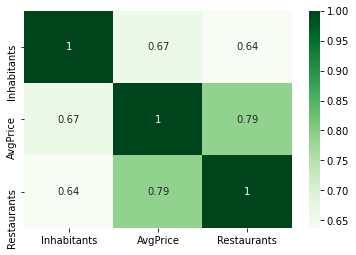

In [289]:
sn.heatmap(corrMatrix, annot=True, cmap="Greens")
plt.show()

In [297]:
start_time = time.time()

# get the geo data from arcgis website
current_url='https://opendata.arcgis.com/datasets/620c2ab925f64ed5979d251ba7753b7f_0.geojson' 
current_data = gpd.read_file(current_url)

# make the important column names international and similar to our analyse_set we already have
current_data.rename(columns = {'Provincie':'Province'},inplace=True)

# setup the geo per province
provinces_df = current_data.dissolve(by='Province', aggfunc = 'sum', as_index=False)

# get the coordinates to put the box on the map
provinces_df['coords'] = provinces_df['geometry'].apply(lambda x: x.representative_point().coords[:])
provinces_df['coords'] = [coords[0] for coords in provinces_df['coords']]

# make the result_set from analyses_set combined with the province_geo
province_geo = provinces_df[['Province','geometry','coords']]
result_set = analyses_set.copy()

# add the geo info by concat the two data frames
result_set = result_set.reset_index(drop=True)
province_geo = province_geo.reset_index(drop=True)
result_set = pd.concat([result_set, province_geo], axis=1)

# In order to draw it on a map, transform the result set into a GeoDataFrame
result_set = GeoDataFrame(result_set)

# show some results
print("--- %s seconds ---" % (time.time() - start_time))
result_set

--- 2.552417039871216 seconds ---


,Inhabitants,AvgPrice,Restaurants,Province,geometry,coords
0,492167.0,241941.0,80.0,Drenthe,"POLYGON ((7.01480 52.87299, 7.04024 52.87290, ...","(6.691751667816376, 52.910004342011504)"
1,416546.0,269589.0,226.0,Flevoland,"MULTIPOLYGON (((5.56195 52.33044, 5.56147 52.3...","(5.516503849933034, 52.43215390816975)"
2,647672.0,230643.0,106.0,Friesland,"MULTIPOLYGON (((6.24726 52.92335, 6.24512 52.9...","(5.82944880094159, 53.1078723154269)"
3,2071972.0,296243.0,260.0,Gelderland,"MULTIPOLYGON (((6.06349 51.86545, 6.06164 51.8...","(6.0839507513518365, 52.12794286740325)"
4,583990.0,219283.0,180.0,Groningen,"MULTIPOLYGON (((7.18924 53.15488, 7.18963 53.1...","(6.887314049045113, 53.1528488882378)"
5,1116137.0,243850.0,279.0,Limburg,"POLYGON ((5.97668 50.80337, 5.97574 50.80235, ...","(5.864041224010732, 51.2602420572922)"
6,2544806.0,310254.0,285.0,Noord-Brabant,"MULTIPOLYGON (((5.67211 51.31509, 5.65610 51.3...","(5.036494077104284, 51.52255808190895)"
7,2853359.0,396601.0,1395.0,Noord-Holland,"MULTIPOLYGON (((5.05628 52.23713, 5.04585 52.2...","(4.822275346611912, 52.56390759020905)"
8,1156431.0,260130.0,181.0,Overijssel,"MULTIPOLYGON (((6.67131 52.15046, 6.67275 52.1...","(6.38203083007505, 52.485994788924046)"
9,1342158.0,371727.0,380.0,Utrecht,"POLYGON ((5.58949 52.00946, 5.59111 52.00730, ...","(5.142520546690204, 52.080452949762545)"


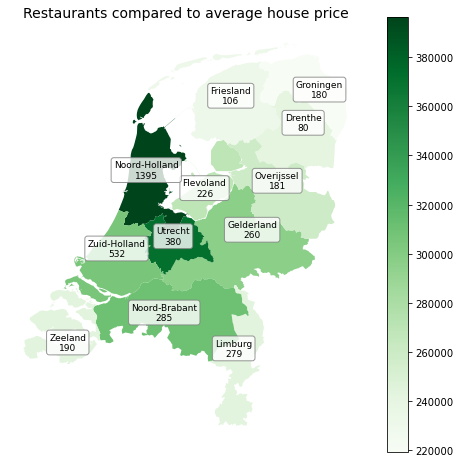

--- 0.8658308982849121 seconds ---


In [298]:
start_time = time.time()

# now let's plot
fig, ax = plt.subplots(1, 1)                 # initializing a figure
fig.set_size_inches(8,8)                     # setting the size

# choose a color schema similar to our correlation plot
cmap = plt.cm.get_cmap('Greens')

# listing all column values from the DataFrame
#values=[int(i) for i in result_set['AvgPrice'].tolist()]     
#bins=sorted(values)

result_set.plot(column='AvgPrice', ax=ax, cmap=cmap, legend=True)

# adding an annotation
bbox_props = dict(boxstyle="round", fc="w", ec="gray", alpha=0.8, lw=1)

for idx, row in result_set.iterrows():
    ax.annotate(s=row['Province']+'\n'+str(int(row['Restaurants'])), xy=row['coords'], color='black',
                 horizontalalignment='center', bbox=bbox_props, fontsize=9)

ax.axis('off')
ax.set_title('Restaurants compared to average house price', fontsize=14)

fig.savefig('Reported_Provinces_NL.png', dpi=400)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))